In [1]:
#Importing All the necessary packages.
import numpy as np # linear algebra
import pandas as pd # data processing, 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing all the  necessary packages for the model building
from itertools import combinations

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA 

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, Holt



import statsmodels.api as sm
import statsmodels.tsa.api as smt

## Data Loading

In [3]:
cocoaDF = pd.read_csv("DATASETS/CocoaPrice.csv") #importing csv file as DataFrame
print(cocoaDF)

           Date    Price
0    1994-10-01  1447.95
1    1994-11-01  1437.05
2    1994-12-01  1399.43
3    1995-01-01  1468.86
4    1995-02-01  1510.55
..          ...      ...
349  2023-11-01  3799.15
350  2023-12-01  3897.04
351  2024-01-01  4087.54
352  2024-02-01  5226.12
353  2024-03-01  6510.16

[354 rows x 2 columns]


In [4]:
cocoaDF.shape #shape of the Dataframe

(354, 2)

In [5]:
cocoaDF.describe() # stats info of the Dataframe


,Price
count,354.000000
mean,1853.000311
std,623.238555
min,874.140000
25%,1396.147500
50%,1805.985000
75%,2168.545000
max,6510.160000


In [6]:
cocoaDF.isnull().sum() # Checking for any null value present

Date     0
Price    0
dtype: int64

In [7]:
cocoaDF.info()
# The data column is in Object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    354 non-null    object 
 1   Price   354 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


## Lets Do Preprocessing of our dataframe

In [8]:
# lets now set the Date column as the index
# Convert the 'Date' column to datetime format
cocoaDF['Date'] = pd.to_datetime(cocoaDF['Date'])
# cocoaDF.set_index('Date',inplace = True)
cocoaDF.head()

,Date,Price
0,1994-10-01,1447.95
1,1994-11-01,1437.05
2,1994-12-01,1399.43
3,1995-01-01,1468.86
4,1995-02-01,1510.55


In [10]:
# Lets Do Preprocessing of our dataframe

mycocoaDF2 =  cocoaDF.copy(deep = True)
# lets now set the Date column as the index

# here I will Convert the 'Date' column to datetime format
mycocoaDF2['Date'] = pd.to_datetime(cocoaDF['Date'])
mycocoaDF2.set_index('Date',inplace = True) # then set the date as index

mycocoaDF2.head()

,Price
Date,
1994-10-01,1447.95
1994-11-01,1437.05
1994-12-01,1399.43
1995-01-01,1468.86
1995-02-01,1510.55


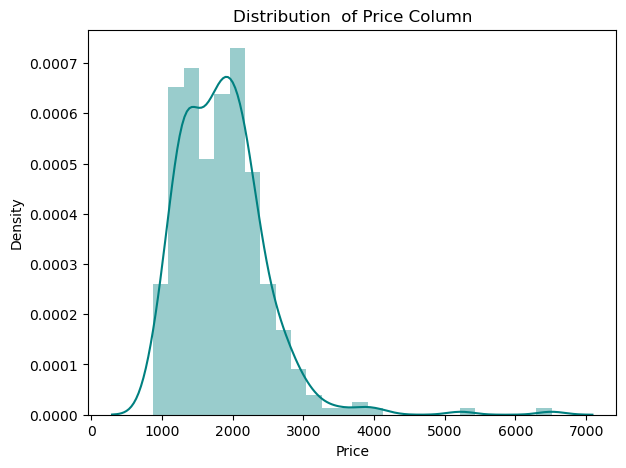

In [11]:
# here. i will now  plot Distribution  of Price Column
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (15,5))
plt.subplot(1,2,1)
sns.distplot(mycocoaDF2['Price'],color = 'teal');
plt.title('Distribution  of Price Column')
plt.show()
fig.tight_layout(pad = 2)

# The normally distributed curve is obtained by analyzing the Price column.


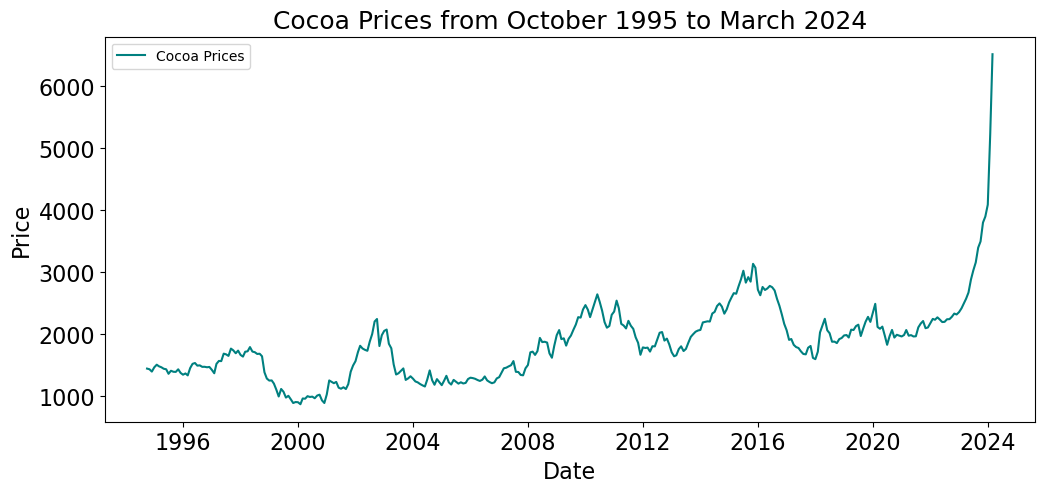

In [12]:

# here. i will now  plot lineplot of Price Column from October 1995 to March 2024
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (12,5))
plt.subplot(1,1,1)
sns.lineplot(x = mycocoaDF2.index ,y = 'Price',data = mycocoaDF2, label='Cocoa Prices',color = 'teal');
plt.title('Cocoa Prices from October 1995 to March 2024',fontsize=18)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()


# It highlights little double peaks, but we will accept it in this circumstance..
# We can definitely see a good trend in price versus date. Three consecutive peaks at regular intervals of time can be noted.


In [13]:
# function testing Stationarity Time Series Analysis for the later use
def functTestStationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Let us Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Rolling Mean & Standard Deviation',fontsize = '16')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



In [14]:
# Supportive Functions for Time Series Analysis for the later use
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

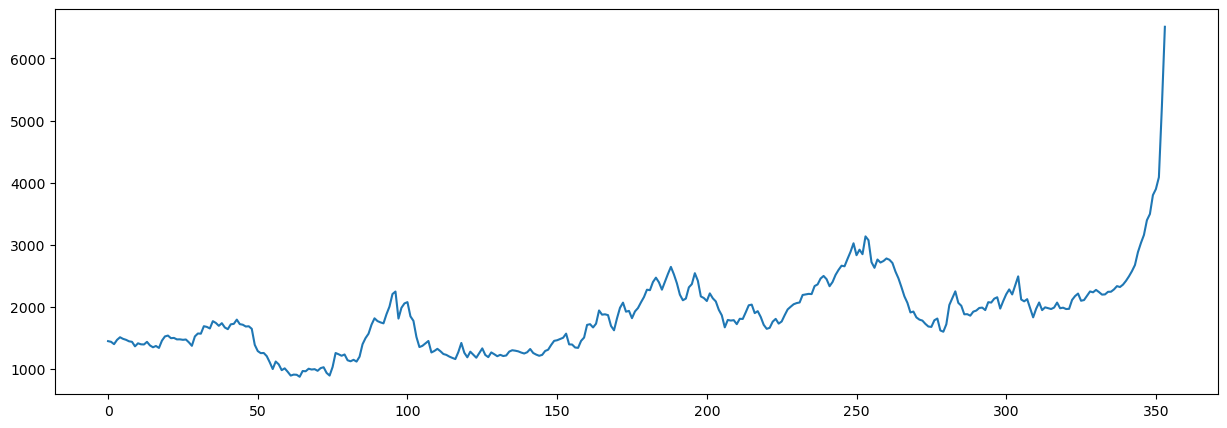

In [15]:
# Let's visualize the Price data for the key components!
plt.figure(figsize = (15,5))
cocoaDF['Price'].plot();

# From the graph below of Cocoa data, we can say that it represents a Multiplicative Model as the data has increasing/decreasing width & height of the peaks.
# We can decompose the multiple components of the Cocoa prices time series

# Decomposition of a Time Series 

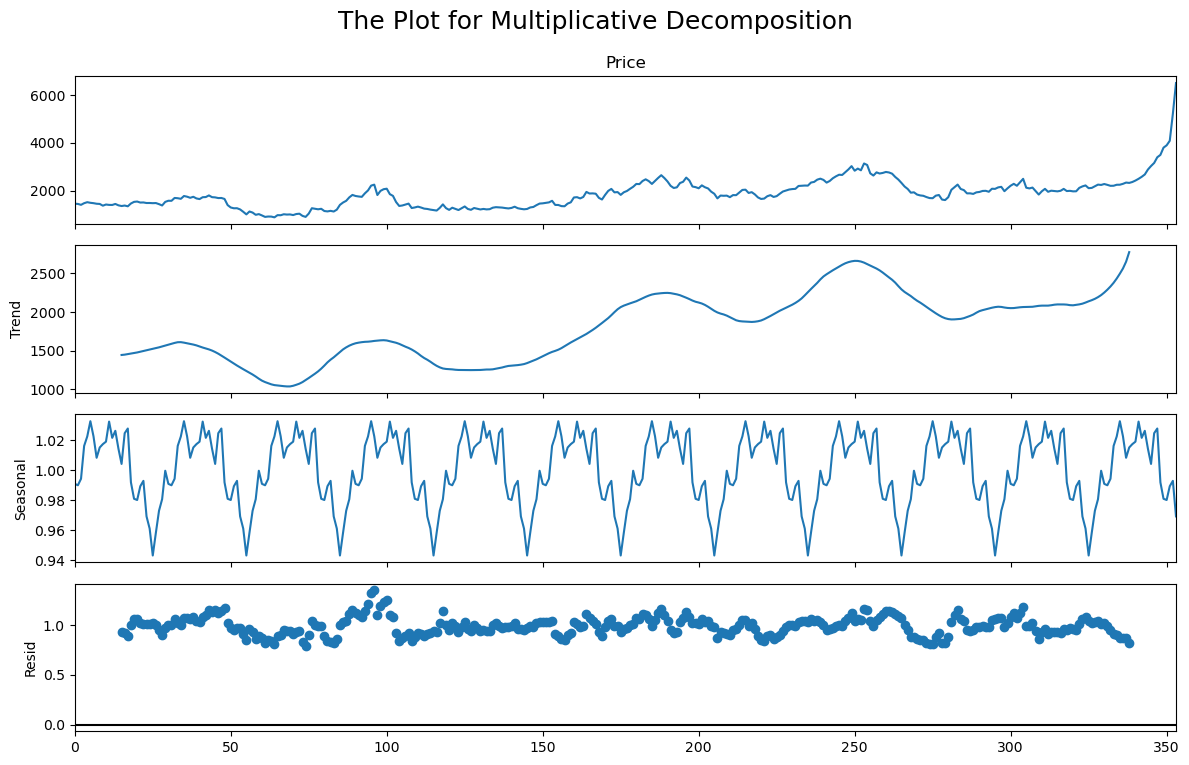

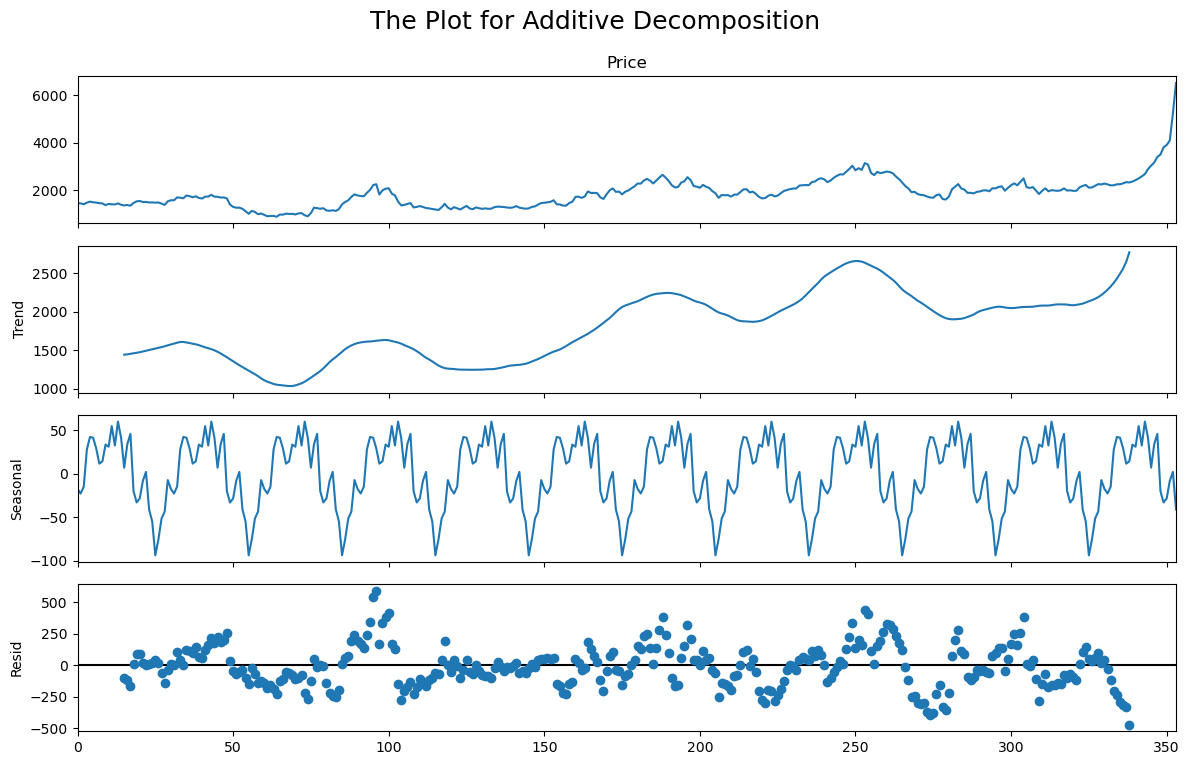

In [24]:
# To decompose a time series, consider series as an additive or multiplicative combination of the base level, trend, seasonal index, and residual term. This is easily accomplished using statsmodels' seasonal_decompose function.

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# below code for  Multiplicative Decomposition 
cPrmultiplicativeDecomposition = seasonal_decompose(cocoaDF['Price'], model='multiplicative', period=30)

# below code for Additive Decomposition
cPradditiveDecomposition = seasonal_decompose(cocoaDF['Price'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (12,8)})
cPrmultiplicativeDecomposition.plot().suptitle('The Plot for Multiplicative Decomposition', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

cPradditiveDecomposition.plot().suptitle('The Plot for Additive Decomposition', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])


plt.show()


# There is some remaining pattern in the additive decomposition residuals when we closely examine them.
# This multiplicative decomposition appears to be rather random, which is a good thing. Therefore, multiplicative decomposition ought to be the optimal choice.


## Testing the Stationarity in the Data

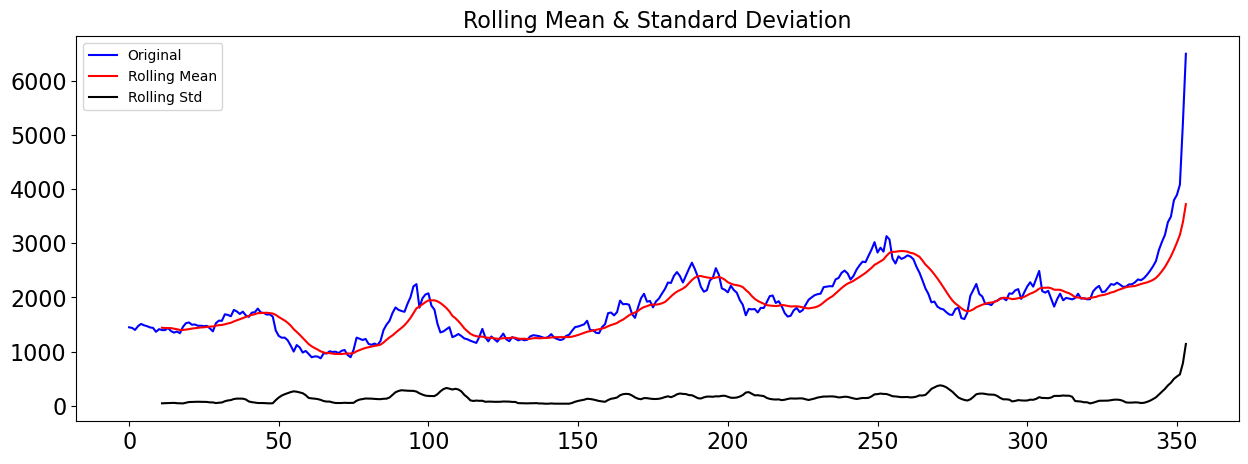

Results of Dickey-Fuller Test:
Test Statistic                   1.528718
p-value                          0.997627
#Lags Used                       7.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64


In [82]:
functTestStationarity(cocoaDF['Price']) 

In [65]:
# p-value (0.99) > 0.05

#We can therefore infer that the aforementioned Cocoa Price Time Series is not stationary and 
# therefore the Null Hypothesis cannot be rejected.

# By subtracting the previous value from the next, or differencing, we can erase trend and seasonality and make the time series stable. 

In [66]:
# log_data = np.log1p(mycocoaDF2)
# log_data.head()

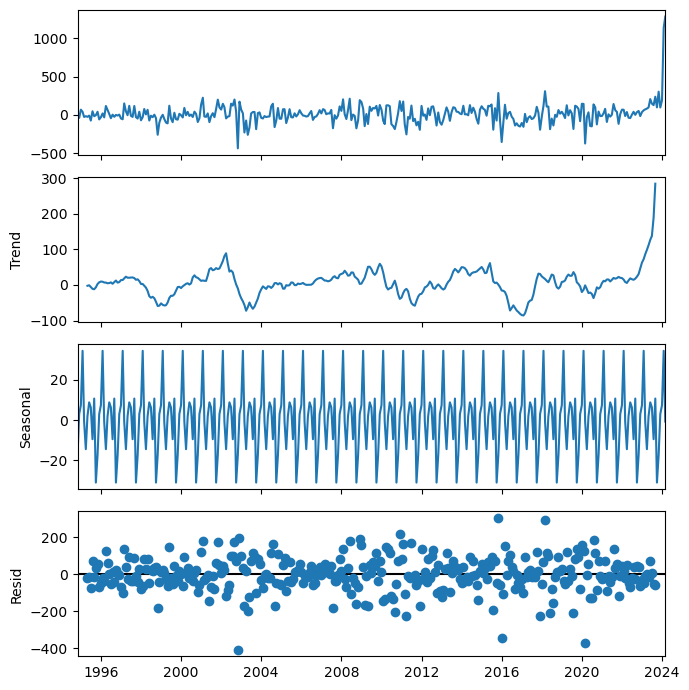

In [67]:
data_diff = mycocoaDF2.diff()
# data_diff = log_data.diff()
data_diff = data_diff.dropna()
# print(data_diff)
# data_diff = data_diff.dropna()
plt.rcParams.update({'figure.figsize': (7,7)})
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

In [68]:
# We now check the stationarity of the (differenced)time series

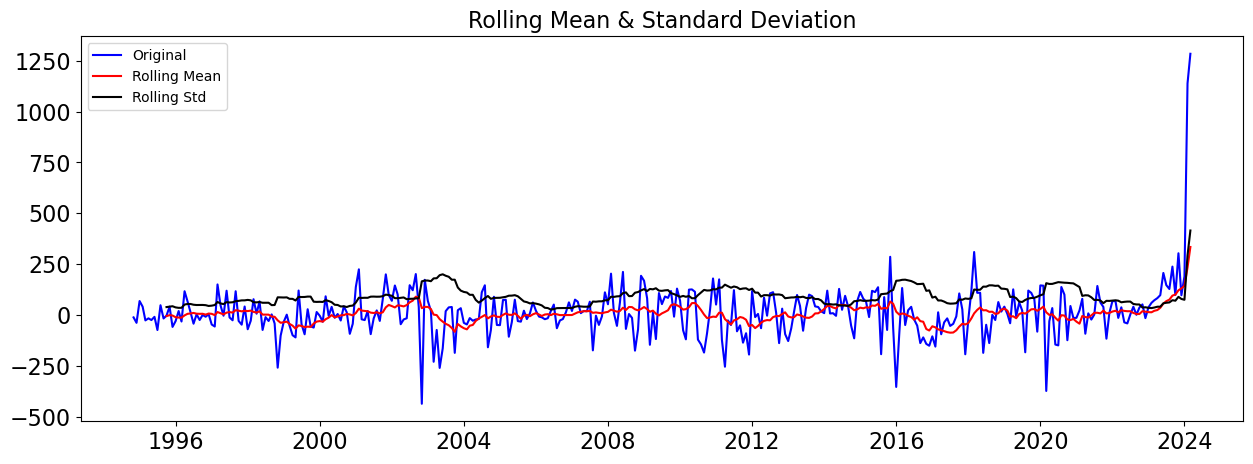

Results of Dickey-Fuller Test:
Test Statistic                   0.074481
p-value                          0.964275
#Lags Used                       6.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64


In [83]:
#  checking for the STtationarity again
functTestStationarity(data_diff) 

In [ ]:
# From the outputs of the Augmented Dickey Fuller Test,
# Rolling Mean is very close to 0.
# Rolling Standard Deviation displays a increase and decrease trend over time.
# Test Statistic : (0.07) > Critical Value (5%) : (-2.86).
# p-value (0.96) > 0.05

# time series failing the stationarity test still we will utilize it based on the data above.

### Building the NAIVE MODEL

In [75]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


# Below I will Split the data into training and testing sets
# myNaivtrainData = mycocoaDF2.loc[:'2023-09']
# myNaivtestData = mycocoaDF2.loc['2023-10':]
data_diff
myNaivtrainData = data_diff.loc[:'2023-09']
myNaivtestData = data_diff.loc['2023-10':]

#  I will Split Define the seasonal period below
seasonal_period = 12  # For monthly data

# Implement the seasonal naive forecast
def functSeasnalNaiveForcst(hstry, seosnl_perd):

    return hstry[-seosnl_perd]

# Now i will  Generate forecasts for the testing set
forecasts = []
for k in range(len(myNaivtestData)):
    forecast = functSeasnalNaiveForcst(myNaivtrainData['Price'], seasonal_period)
    forecasts.append(forecast)
#    # lets now Add the observed value to the training set for the next iteration
    myNaivtrainData = pd.concat([myNaivtrainData, pd.DataFrame(myNaivtestData.iloc[k]).transpose()], axis=0)


In [76]:
 # I will also Calculate RMSE for naive model to check the accuracy
rmse = np.sqrt(mean_squared_error(myNaivtestData['Price'], forecasts))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 674.6720473805526


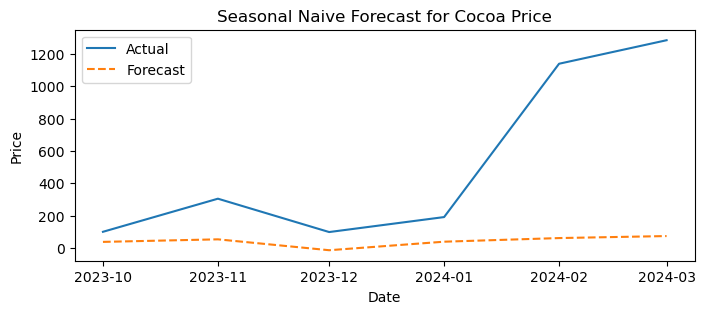

In [77]:
# Visualize the forecasted values and actual values
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8,3))
plt.plot(myNaivtestData.index, myNaivtestData['Price'], label='Actual')
plt.plot(myNaivtestData.index, forecasts, label='Forecast', linestyle='--')
plt.title('Seasonal Naive Forecast for Cocoa Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Exponential Smoothing

In [86]:
### Now i will carry out Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pylab import rcParams
rcParams['figure.figsize'] = 20,5
expsDf = cocoaDF.copy(deep=True)
expsDf.set_index('Date',inplace=True)
expsDf

,Price
Date,
1994-10-01,1447.95
1994-11-01,1437.05
1994-12-01,1399.43
1995-01-01,1468.86
1995-02-01,1510.55
...,...
2023-11-01,3799.15
2023-12-01,3897.04
2024-01-01,4087.54


### Moving Average Method

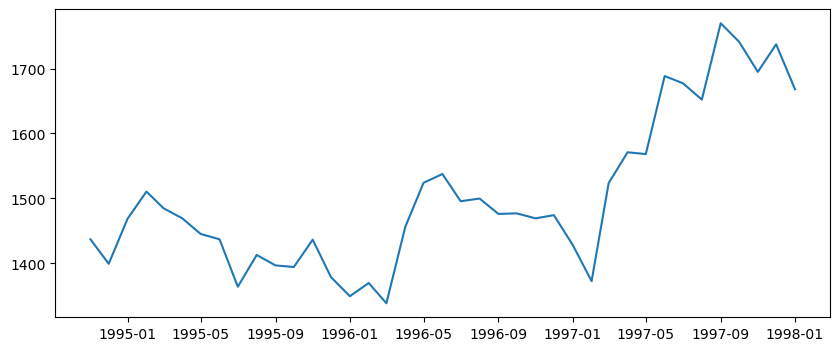

In [96]:
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (10,4))
plt.plot(expsDf[1:40]['Price'])

plt.show()
#the every year during nov dec the price goes down and and it goes up during in May and september month          
#there is a seaonality that is sure
# The Chart is also going up that means there is a Trend as well

In [88]:
# What is moving Average? # what is  window ? (rolling average or running average or moving mean or rolling mean)
# It is a calculation to analyze data points by creating a series of averages of different selections
#  MA -  going behind in the analyse  and taking an average of how many window we want

# rolling average transform
cPrrollingseries = expsDf[1:50].rolling(window=5)

rollingmean = cPrrollingseries.mean() # finding rolling mean MA(5) -(MovingAverage)
print(rollingmean.head(10))

               Price
Date                
1994-11-01       NaN
1994-12-01       NaN
1995-01-01       NaN
1995-02-01       NaN
1995-03-01  1460.160
1995-04-01  1466.602
1995-05-01  1475.780
1995-06-01  1469.436
1995-07-01  1440.146
1995-08-01  1425.764


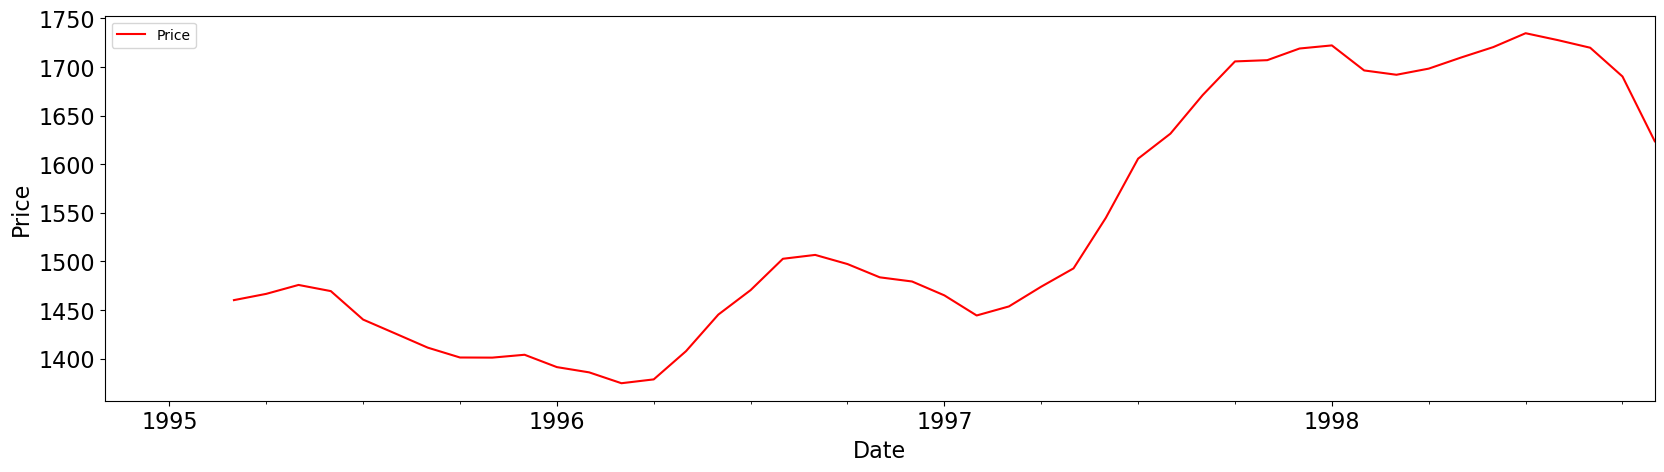

In [97]:
rollingmean.plot(color='red')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


# if you observe the above chart and compare it with below chart the seasonlaity has been smoothened.
# The blue is having morre variation and red is having less variation
# The red represents the smoothened time series on moving average and blue is the original time series .

In [171]:
# rolling average transform
rollingseries = expsDf[1:50].rolling(window=10)
rollingmean = rollingseries.mean() # finding rolling mean MA(5) -(MovingAverage)
print(rollingmean.head(10))

               Price
Date                
1994-11-01       NaN
1994-12-01       NaN
1995-01-01       NaN
1995-02-01       NaN
1995-03-01       NaN
1995-04-01       NaN
1995-05-01       NaN
1995-06-01       NaN
1995-07-01       NaN
1995-08-01  1442.962


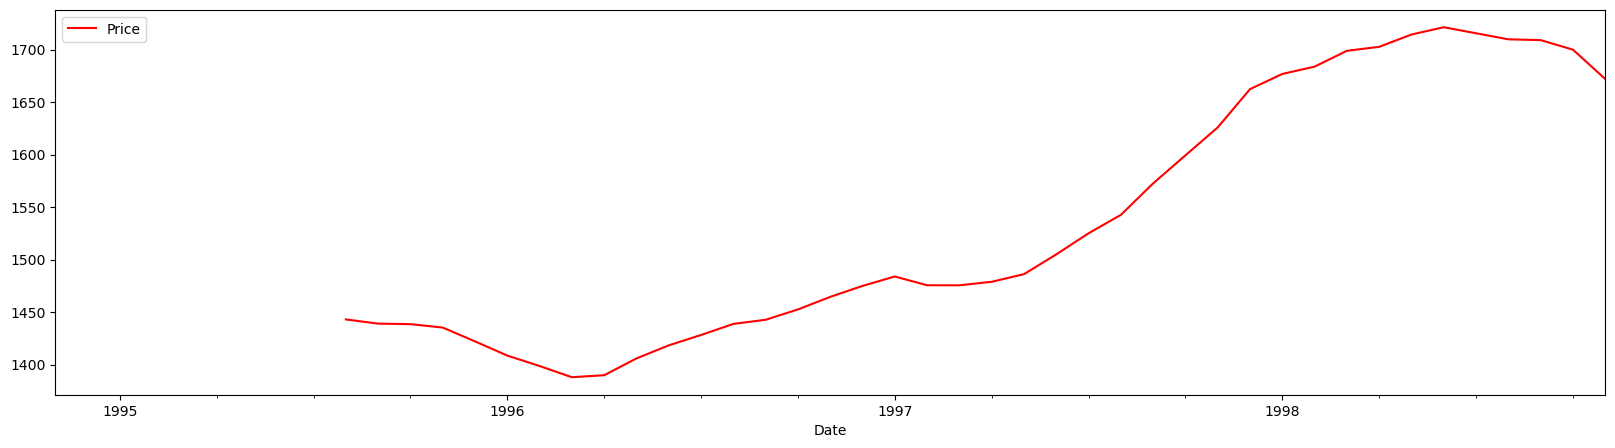

In [172]:
rollingmean.plot(color='red')
plt.show()

#  if we increase the window the curve becomes little more smooth

## Simple Exponential Smoothing

In [99]:
# Exponential smoothing- simple
mySES =expsDf[1:50]
cPrfit1 = SimpleExpSmoothing(mySES).fit(smoothing_level=0.2,optimized=False)
cPrfit2 = SimpleExpSmoothing(mySES).fit(smoothing_level=0.8,optimized= False)

# smoothing_level here is nothing but an alpha value 
# for Fit 1 is have given 0.2 and for fit 2 = 0.8

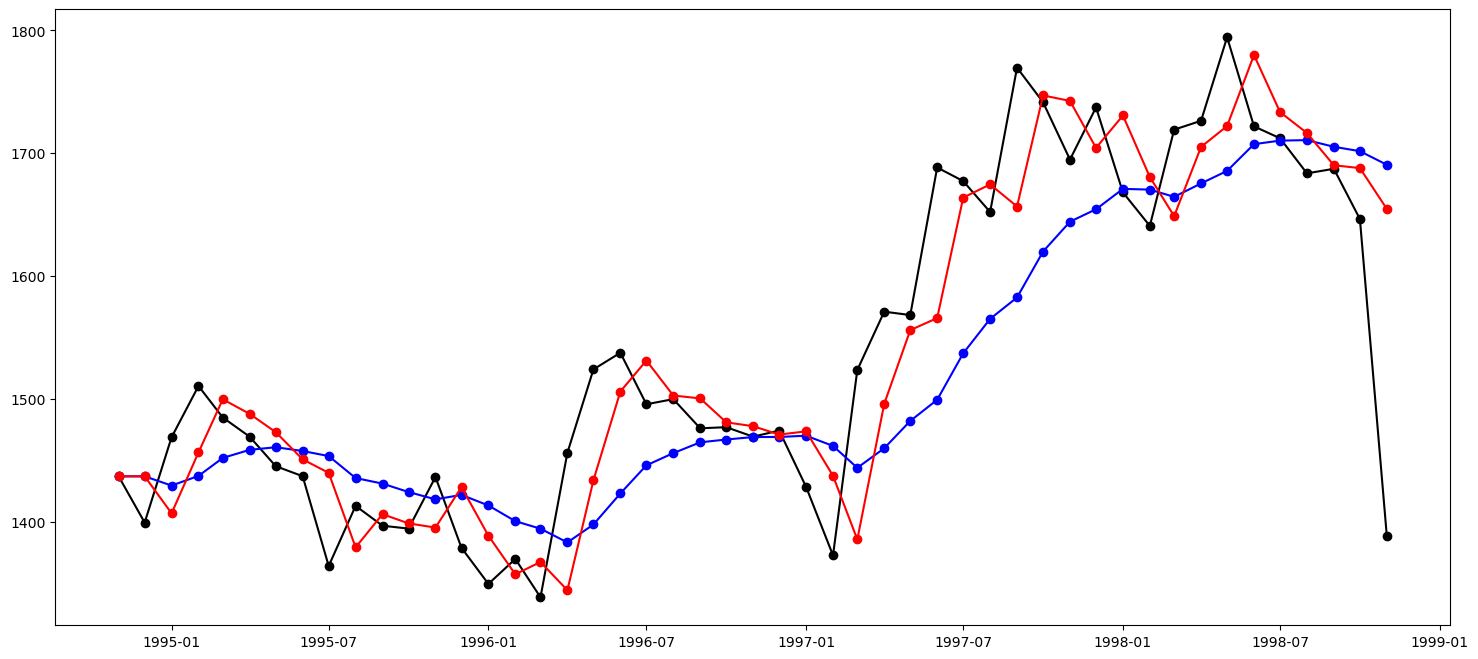

In [113]:
plt.figure(figsize=(18,8))
plt.plot(mySES,marker='o', color='black')
# plt.xticks(rotation=30)

plt.plot(cPrfit1.fittedvalues, marker='o',color='blue')
plt.plot(cPrfit2.fittedvalues,marker='o',color='red')


# The value of alpha tells you how much weightage u wanna give to the most recent observation.
# so here Black is the original curve
# Blue one we have given less value of alpha (0.8 - more value to the recent observation)
# Red one we have given less value of alpha (0.2 - more value to the recent observation)

# If you give more wieght to the most recent observations then your  curve(i.e red) fill follow ur original curve.
# blue curve is less value to the recent observations


In [101]:
# Apply exponential smoothing using a basic Holt's method

fit1 = Holt(expsDf[1:50]).fit() # linear Trend
fit2 = Holt(expsDf[1:50], exponential=True).fit() # exponential trend

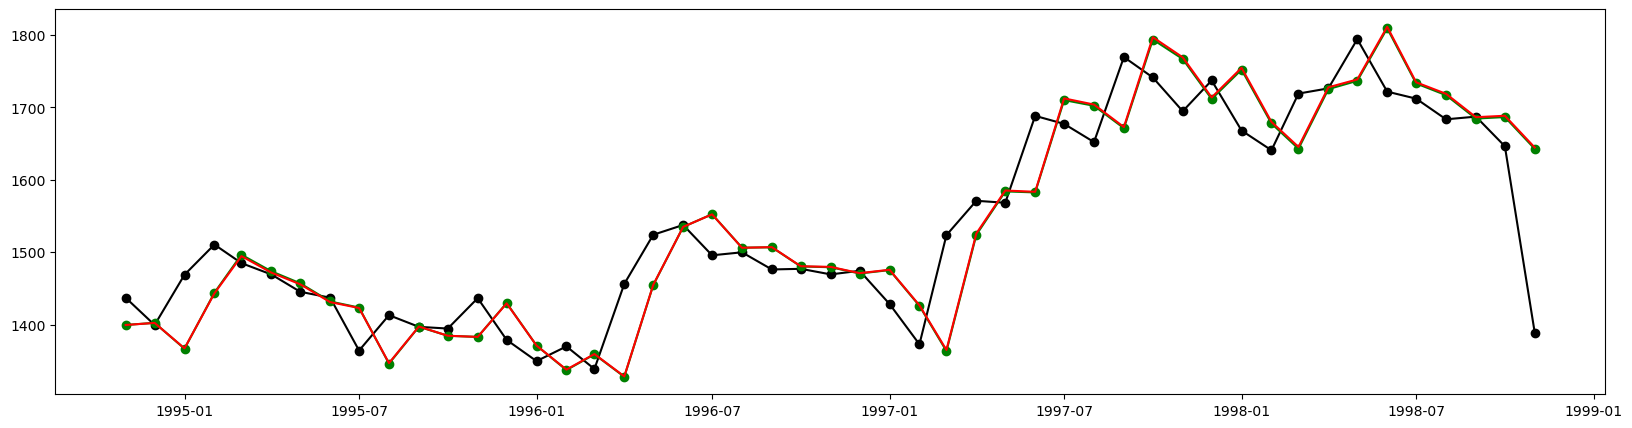

In [102]:
plt.plot(expsDf[1:50],marker='o',color='black')
# plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker='o',color='green')
plt.plot(fit2.fittedvalues,color='red' )

### Simple Exponential Smoothing` for entire Data

In [104]:
# Apply simple exponential smoothing to full data
expsDf1= expsDf.copy(deep=True)
alphaValue = 0.2
sesmodel = SimpleExpSmoothing(expsDf1)
mysesresults = sesmodel.fit(smoothing_level=alphaValue, optimized=False)
expsDf1['Smoothed'] = mysesresults.fittedvalues

In [105]:
# Lets now Calculate RMSE value for my Simple Exponential Smoothing model
rmse = np.sqrt(mean_squared_error(expsDf1['Price'], expsDf1['Smoothed']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 261.5139948164754


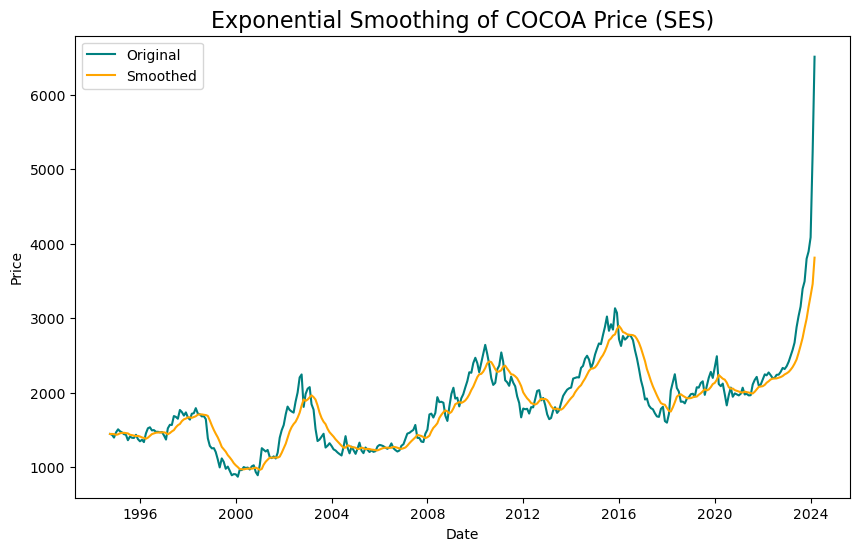

In [125]:
# Plot original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(expsDf1['Price'], label='Original',color='teal')
plt.plot(expsDf1['Smoothed'], label='Smoothed',color='orange')
plt.title('Exponential Smoothing of COCOA Price (SES)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

# The original COCOA price data is represented by the solid Teal color line, while the smoothed data is represented by the orange line.
# # The SES line i.e orange color line closely follows the original data but it tends to lag behind sudden changes or trends due to its simplicity.  
# It is suitable for data without trends or seasonal patterns.


## Holt Method ES

In [177]:

ESHoltsdf = cocoaDF.copy(deep=True)

ESHoltsdf.set_index('Date', inplace=True)
ts = ESHoltsdf['Price']  # Extracting the price column as a Series

# Holt's Method (Double Exponential Smoothing)
alphaVal = 0.8  # Smoothing parameter for level
betaVal = 0.2   # Smoothing parameter for trend
myholtModel = ExponentialSmoothing(ts, trend='add')
myholtResults =myholtModel.fit(smoothing_level=alphaVal, smoothing_slope=betaVal)
ESHoltsdf['Holt'] = myholtResults.fittedvalues

# Holt-Winters' Method (Triple Exponential Smoothing)
alphaVal = 0.8  # Smoothing parameter for level
betaVal = 0.2   # Smoothing parameter for trend
gamma = 0.6  # Smoothing parameter for seasonality
season_period = 2  # Seasonal period (assuming bi-weekly)
HoltWinModel = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=season_period)
HoltWinResult = HoltWinModel.fit(smoothing_level=alphaVal, smoothing_slope=betaVal, smoothing_seasonal=gamma)
ESHoltsdf['Holt_Winters'] = HoltWinResult.fittedvalues


In [178]:
# Lets now Calculate RMSE value for my Holt Exponential Smoothing 
rmse = np.sqrt(mean_squared_error(expsDf1['Price'], ESHoltsdf['Holt']))

print(f"Root Mean Squared Error for Holt Exponential Smoothing model (RMSE): {rmse}")

Root Mean Squared Error for Holt Exponential Smoothing model (RMSE): 132.0712937052342


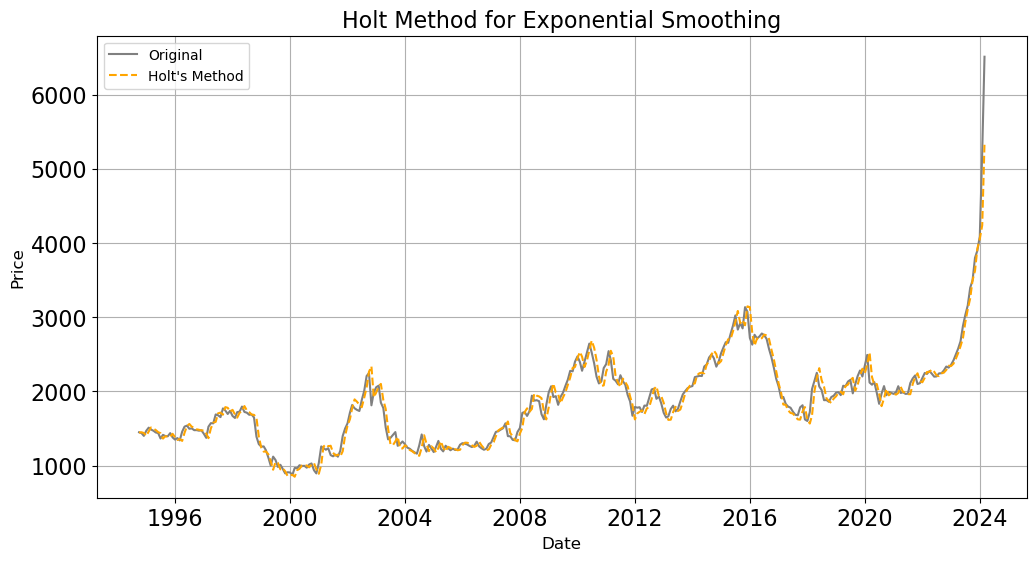

In [179]:
# below plotting the graph now for Holt method
plt.figure(figsize=(12, 6))
plt.plot(ESHoltsdf['Price'], label='Original',color='grey')
plt.plot(ESHoltsdf['Holt'], label="Holt's Method", linestyle='--', color='orange')
plt.title('Holt Method for Exponential Smoothing',fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# The Holt's method line (dashed line) captures both the level and trend of the data, providing smoother forecasts compared to SES.
# It's suitable for data with a trend but no seasonality.

Root Mean Squared Error (RMSE): 1095.6321047024921
Actual Data :
Date
2023-10-01    3495.03
2023-11-01    3799.15
2023-12-01    3897.04
2024-01-01    4087.54
2024-02-01    5226.12
2024-03-01    6510.16
Name: Price, dtype: float64
--------------
Forcasted Data :
2023-10-01    3495.430530
2023-11-01    3623.920680
2023-12-01    3752.410829
2024-01-01    3880.900978
2024-02-01    4009.391127
2024-03-01    4137.881276
Freq: MS, dtype: float64


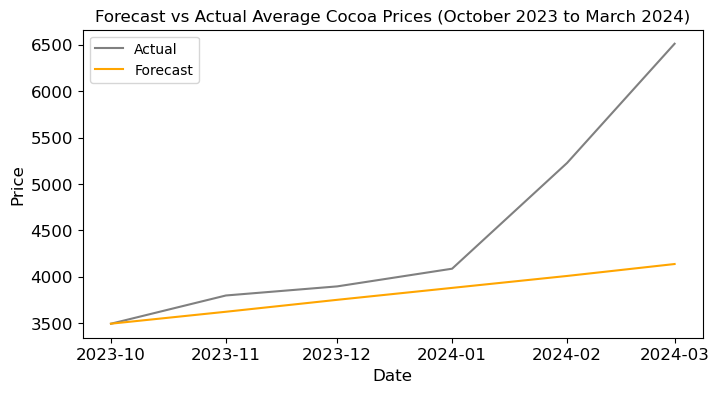

In [185]:
HoltsForecast = cocoaDF.copy(deep=True)
HoltsForecast.set_index('Date', inplace=True)

# Here Dividing the dataset into training and testing sets
HoltstrainData = HoltsForecast.loc[:'2023-09-30']
HoltstestData = HoltsForecast.loc['2023-10-01':'2024-03-31']

# Extracting the price column as a Series
holtstrain_ts = HoltstrainData['Price']
holtstest_ts = HoltstestData['Price']

# Fit the Holt's Method model on the training data
alphaVal = 0.8  # Smoothing parameter for level
betaVal = 0.2   # Smoothing parameter for trend
holt_model = ExponentialSmoothing(holtstrain_ts, trend='add')
holt_results = holt_model.fit(smoothing_level=alphaVal, smoothing_slope=betaVal)

# lets now generate forecasts for the test data
forecast_period = len(test_data)  # Number of periods to forecast
forecast = holt_results.forecast(forecast_period)

# EVALUATION Meterics for Actual vs Forecasted data
rmse = np.sqrt(mean_squared_error(holtstest_ts, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Actual Data :")
print(HoltstestData['Price'])
print("--------------")
print(f"Forcasted Data :")
print(forecast)


# lets now plot the actual and forecasted values for the test data
plt.figure(figsize=(8, 4))
plt.plot(test_data.index, holtstest_ts, label='Actual', color='grey')  # Plot actual values
plt.plot(test_data.index, forecast, label="Forecast", color='orange')  # Plot forecasted values
plt.title('Forecast vs Actual Average Cocoa Prices (October 2023 to March 2024)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()


In [182]:
# Lets now Calculate RMSE value for Holt-Winters' Method
rmse = np.sqrt(mean_squared_error(expsDf1['Price'], ESHoltsdf['Holt_Winters']))
print(f"Root Mean Squared Error Holt-Winters' Method (RMSE): {rmse}")

Root Mean Squared Error Holt-Winters' Method (RMSE): 153.4779701942656


## Holt Winters Method

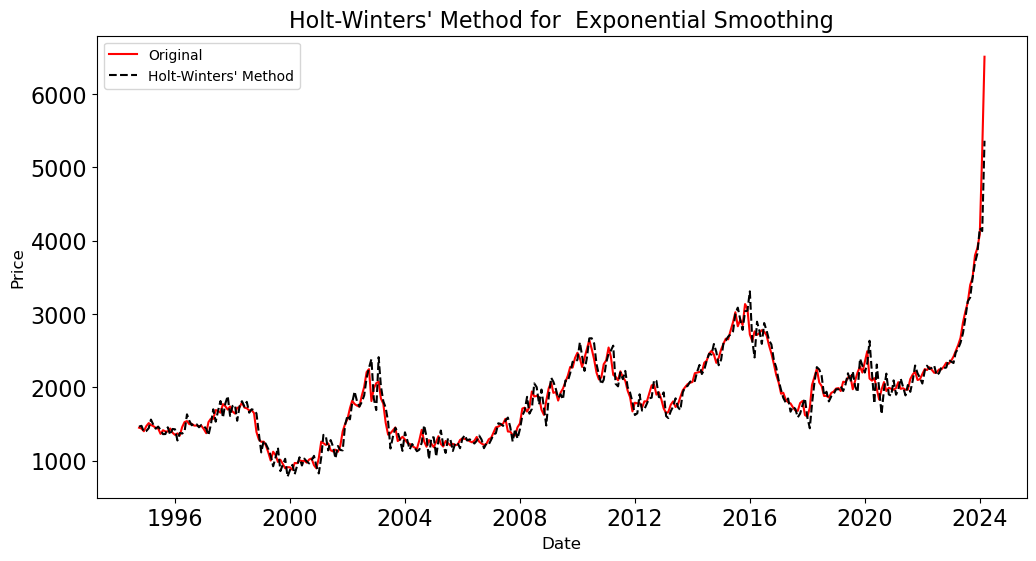

In [183]:
# Plotting the graph now for Holt Winters method
plt.figure(figsize=(12, 6))
plt.plot(ESHoltsdf['Price'], label='Original',color='red')
plt.plot(ESHoltsdf['Holt_Winters'], label="Holt-Winters' Method", linestyle='--',color="black")
plt.title("Holt-Winters' Method for  Exponential Smoothing", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
# plt.grid(True)
plt.show()
# The Holt-Winters' method line (dashed line) captures the level, trend, and seasonality of the data, providing even smoother forecasts for data with both trend and seasonality. It's suitable for data with both trend and seasonality.

Root Mean Squared Error (RMSE): 3829.4059723609753
Actual Data :
Date
2023-10-01    3495.03
2023-11-01    3799.15
2023-12-01    3897.04
2024-01-01    4087.54
2024-02-01    5226.12
2024-03-01    6510.16
Name: Price, dtype: float64
--------------
Forcasted Data :
2024-04-01    7372.861872
2024-05-01    7255.394942
2024-06-01    8347.461516
2024-07-01    8229.994586
2024-08-01    9322.061160
2024-09-01    9204.594230
Freq: MS, dtype: float64


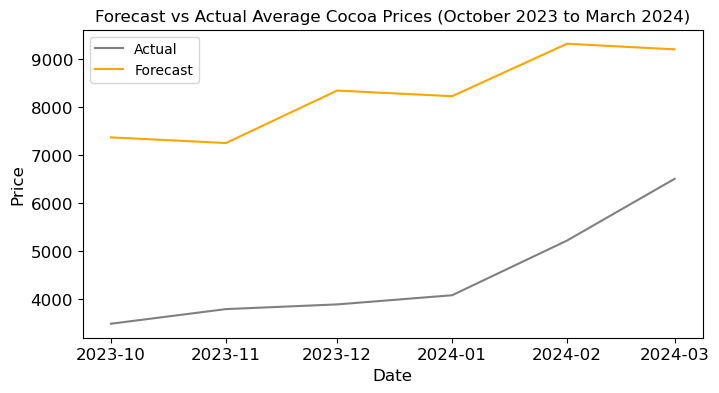

In [184]:
HoltWintersForecast = cocoaDF.copy(deep=True)
HoltWintersForecast.set_index('Date', inplace=True)

# Here Dividing the dataset into training and testing sets
HoltstrainData = HoltWintersForecast.loc[:'2023-09-30']
HoltstestData = HoltWintersForecast.loc['2023-10-01':'2024-03-31']

# Extracting the price column as a Series
holtstrain_ts = HoltstrainData['Price']
holtstest_ts = HoltstestData['Price']

# Fit the Holt's Method model on the training data
alphaVal = 0.8  # Smoothing parameter for level
betaVal = 0.2   # Smoothing parameter for trend
gammaVal = 0.6  # Smoothing parameter for seasonality

HoltWinModel = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=season_period)
HoltWinResult = HoltWinModel.fit(smoothing_level=alphaVal, smoothing_slope=betaVal, smoothing_seasonal=gamma)

# lets now generate forecasts for the test data
forecast_period = len(test_data)  # Number of periods to forecast
forecast = HoltWinResult.forecast(forecast_period)

# EVALUATION Meterics for Actual vs Forecasted data
rmse = np.sqrt(mean_squared_error(holtstest_ts, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Actual Data :")
print(HoltstestData['Price'])
print("--------------")
print(f"Forcasted Data :")
print(forecast)

# lets now plot the actual and forecasted values for the test data
plt.figure(figsize=(8, 4))
plt.plot(test_data.index, holtstest_ts, label='Actual', color='grey')  # Plot actual values
plt.plot(test_data.index, forecast, label="Forecast", color='orange')  # Plot forecasted values
plt.title('Forecast vs Actual Average Cocoa Prices (October 2023 to March 2024)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()

### ARIMA Model

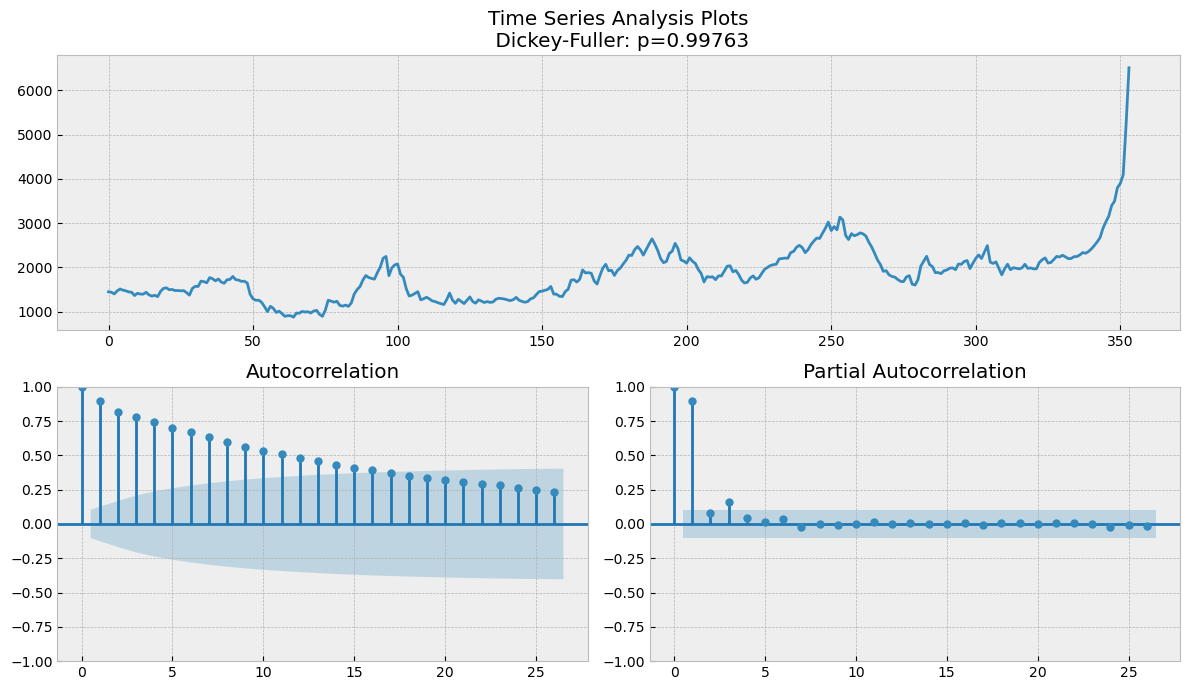

In [95]:
# Lets build a Modeling
# ARIMA

tsplot(cocoaDF['Price'])

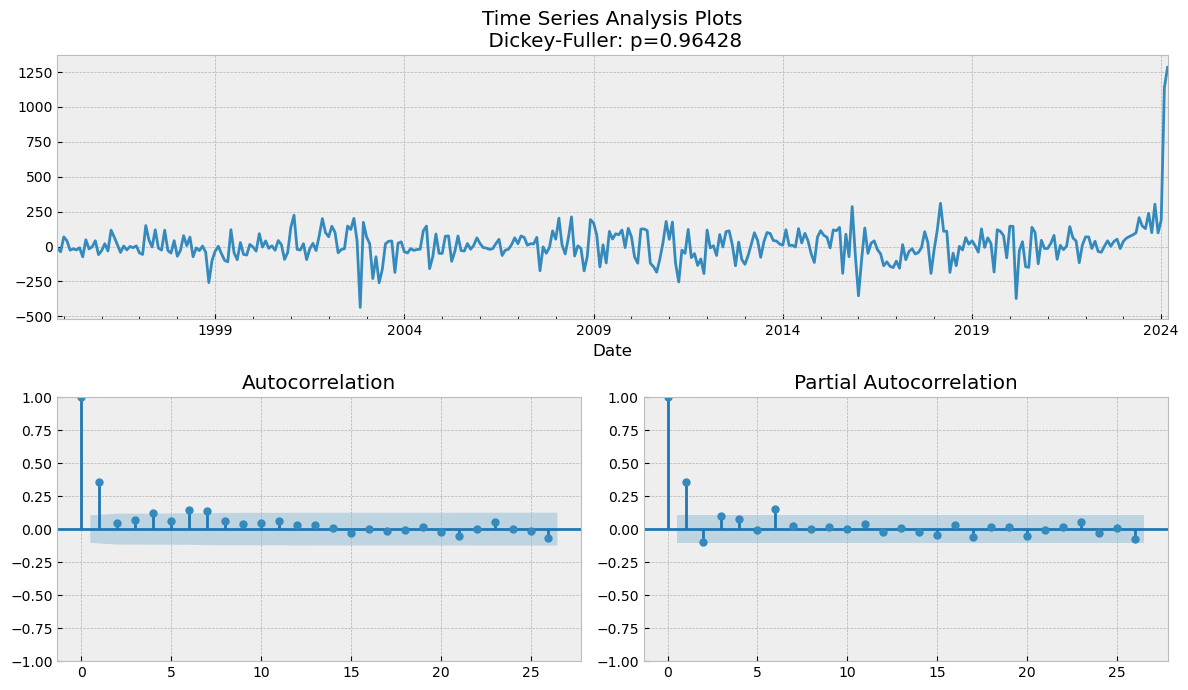

In [192]:
tsplot(data_diff['Price'])

In [193]:
# Using the previously stated selection criteria, the following ARIMA model order is chosen from the plots above
# p : 2
# d : 1
# q : 2
# The Log Price data, which is non-differenced and non-stationary passes test for model fitting.

In [142]:
from statsmodels.tsa.arima.model import ARIMA
cPrArimaModel = ARIMA(cocoaDF['Price'],order = (2,1,2))
model_fit = cPrArimaModel.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  354
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2192.190
Date:                Sun, 05 May 2024   AIC                           4394.379
Time:                        16:48:09   BIC                           4413.712
Sample:                             0   HQIC                          4402.072
                                - 354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9542      0.222      4.298      0.000       0.519       1.389
ar.L2          0.0302      0.201      0.150      0.881      -0.364       0.424
ma.L1         -0.4982      0.229     -2.176      0.0

##  Forecast for Arima the average prices for the 6 months from October 2023 to March 2024

In [9]:
#Sample Forecasting :

# We divide the data into train and test dataset acc to TABA Requirenment

In [198]:

train = mycocoaDF2.loc[:'2023-09'].squeeze()
test =  mycocoaDF2.loc['2023-10':].squeeze()
print('ARIMA MODEL Results Predicted VS Actual')

arimaFChistory = [x for x in train]
myArimaPredictions = []

for t in range(len(test)):
    arimaModel = ARIMA(arimaFChistory, order=(2,1,2))
    model_fit = arimaModel.fit()
    output = model_fit.forecast()
    yat = output[0]
    myArimaPredictions.append(float(yat))
    obs = test[t]
    arimaFChistory.append(obs)
    print('predicted = %f, expected = %f' % (yat, obs))



ARIMA MODEL Results Predicted VS Actual
predicted = 3443.673223, expected = 3495.030000
predicted = 3488.127481, expected = 3799.150000
predicted = 3852.408061, expected = 3897.040000
predicted = 3906.725435, expected = 4087.540000
predicted = 4157.024289, expected = 5226.120000
predicted = 5574.676643, expected = 6510.160000


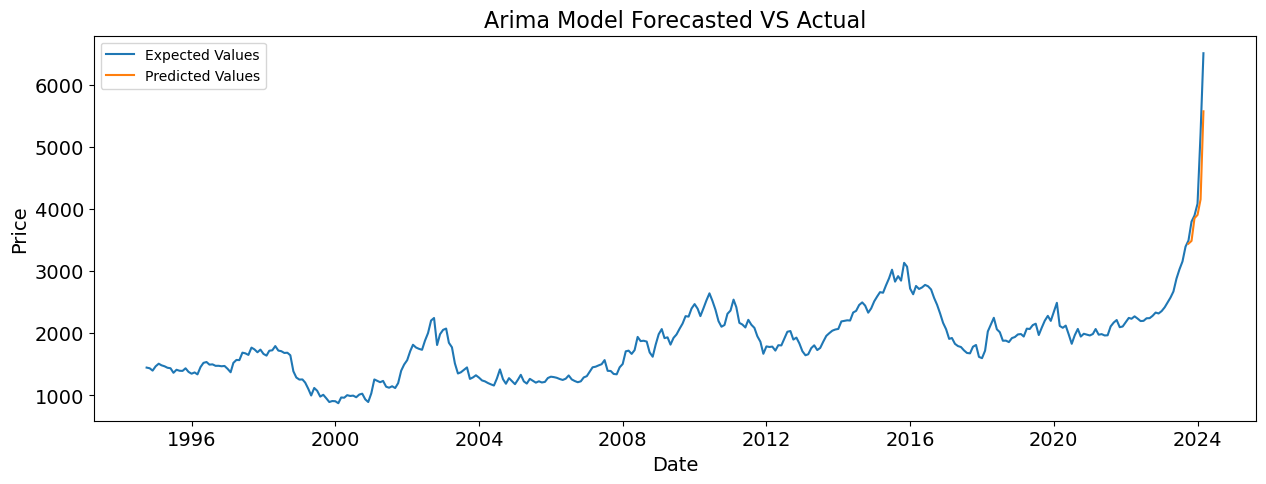

In [195]:
predictions_series = pd.Series(myArimaPredictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(mycocoaDF2['Price'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.title("Arima Model Forecasted VS Actual",fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Predicted Values and Expected Values are very close.
# The above trained ARIMA model has performed quite well in forecasting in - sample values

In [199]:
RMSEValue = np.sqrt(mean_squared_error(test,myArimaPredictions))
print('Test RMSE: %.4f' % RMSEValue)

Test RMSE: 598.9092


In [148]:
# Test RMSE value is ok . But we will check

# SARIMA


In [207]:
# SARIMA
# Seasonal Auto Regressive Integrated Moving Average

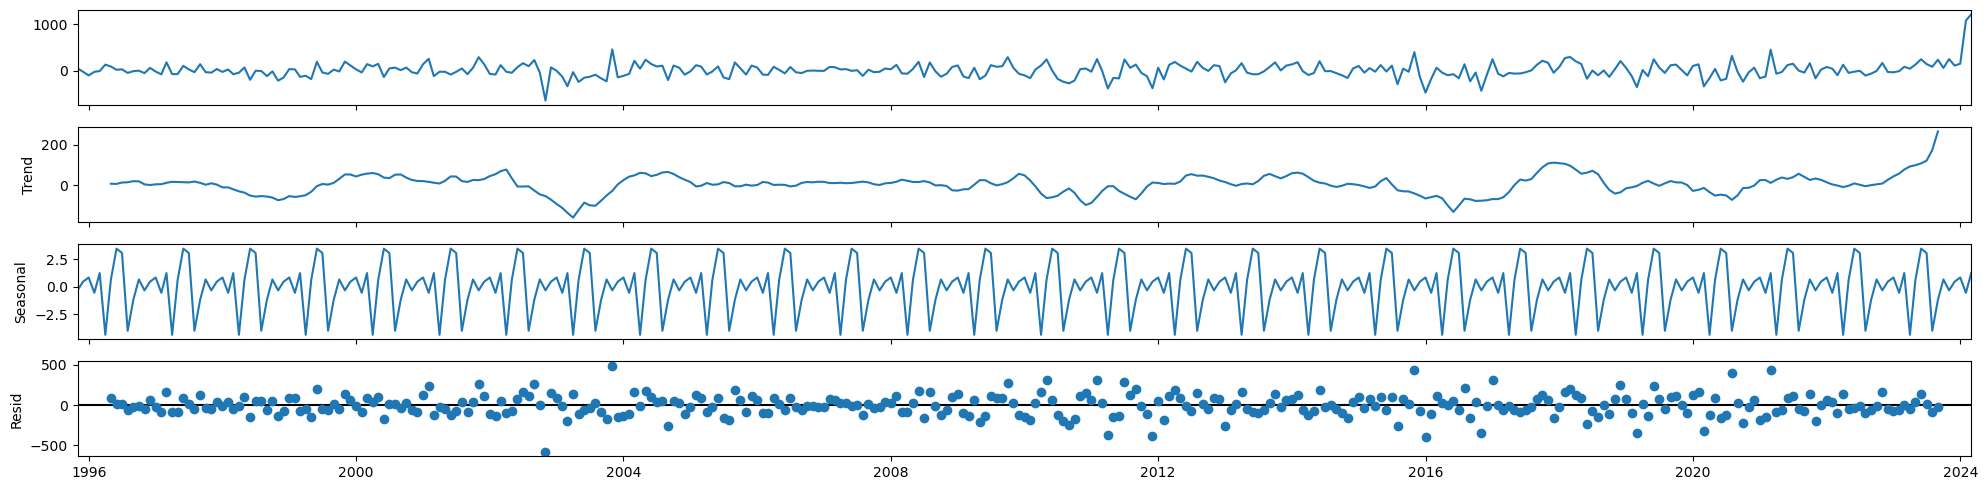

In [201]:
dataDiffrence_seas = data_diff.diff(12)
dataDiffrence_seas = dataDiffrence_seas.dropna()
dec = sm.tsa.seasonal_decompose(dataDiffrence_seas,period = 12)
dec.plot()
plt.show()
# Our data is in monthly format and the seasonal period is of 1 year.
# Hence, we difference the already differenced data by a periodicity M value of 12.


In [202]:
# The seasonality of the data has not completely died down but it's values have been dropped.
# We will check this seasonal differenced data for stationarity.

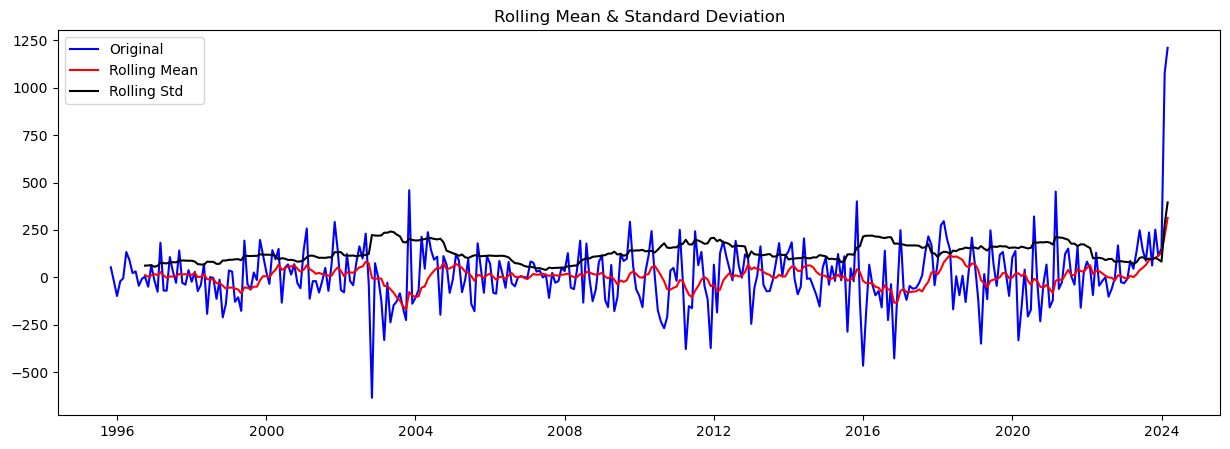

Results of Dickey-Fuller Test:
Test Statistic                  -2.702169
p-value                          0.073664
#Lags Used                      12.000000
Number of Observations Used    328.000000
Critical Value (1%)             -3.450445
Critical Value (5%)             -2.870392
Critical Value (10%)            -2.571486
dtype: float64


In [170]:
functTestStationarity(dataDiffrence_seas['Price'])

In [171]:
# From the outputs of the Augmented Dickey Fuller Test,
# Rolling Mean is very close to 0.
# Rolling Standard Deviation is near about constant with certain crests - troughs present throughout.
# Critical Value (5%) : (-2.87) < Test Statistic : (-2.7). We can say that the time series is not stationary  as the Test Statistic is more than Critical Value.
# 0.05 < p-value (0.07)

# Since the p-value (0.073664) is greater than the commonly used significance level of 0.05, we fail to reject the null hypothesis.

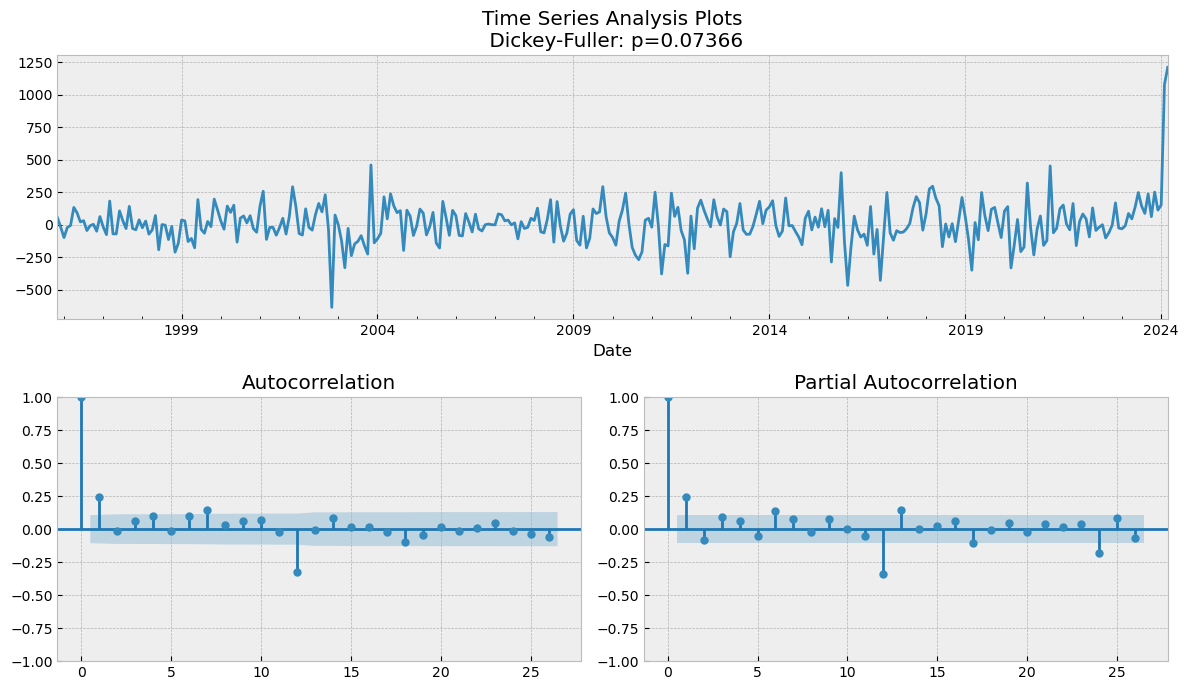

In [172]:
# plotting PACF and ACF graphs
tsplot(dataDiffrence_seas['Price'])

In [173]:
# For the SARIMA model, order of (p,d,q) will be same as the order of the ARIMA model above.
# For (P,D,Q,M) :
# P : 0
# D : 1
# Q : 1
# M : 12

In [208]:
sarimaModel = sm.tsa.statespace.SARIMAX(mycocoaDF2['Price'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = sarimaModel.fit()
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11798D+00    |proj g|=  5.08233D-02

At iterate    5    f=  6.09204D+00    |proj g|=  5.32339D-03

At iterate   10    f=  6.08436D+00    |proj g|=  8.50104D-03

At iterate   15    f=  6.07498D+00    |proj g|=  1.06594D-02

At iterate   20    f=  6.05882D+00    |proj g|=  8.15353D-04

At iterate   25    f=  6.05817D+00    |proj g|=  3.12784D-02

At iterate   30    f=  6.05214D+00    |proj g|=  1.84125D-03

At iterate   35    f=  6.05121D+00    |proj g|=  7.07230D-03
  ys=-1.486E-03  -gs= 2.000E-03 BFGS update SKIPPED

At iterate   40    f=  6.03479D+00    |proj g|=  5.26515D-02

At iterate   45    f=  6.03080D+00    |proj g|=  7.69198D-04

At iterate   50    f=  6.03067D+00    |proj g|=  5.12805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


##  Forecast for Sarima the average prices for the 6 months from October 2023 to March 2024.


In [205]:
size = int(len(mycocoaDF2) - 30)
# train, test = mycocoaDF2['Price'][0:size], mycocoaDF2['Price'][size:len(mycocoaDF2)]
train = mycocoaDF2.loc[:'2023-09'].squeeze()
test =  mycocoaDF2.loc['2023-10':].squeeze()
print('SARIMA MODEL Forcasted Vs Actual')

# Initialize SARIMA model
sarimaModel = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
model_fit = sarimaModel.fit(disp=False)

# below code is for the forecasting step
sarimapredictions = model_fit.forecast(steps=len(test))

# Print predicted and expected values
for i in range(len(sarimapredictions)):
    print('predicted = %f, expected = %f' % (sarimapredictions[i], test[i]))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 3363.408475, expected = 3495.030000
predicted = 3348.673482, expected = 3799.150000
predicted = 3357.263191, expected = 3897.040000
predicted = 3365.157845, expected = 4087.540000
predicted = 3409.653684, expected = 5226.120000
predicted = 3409.243419, expected = 6510.160000


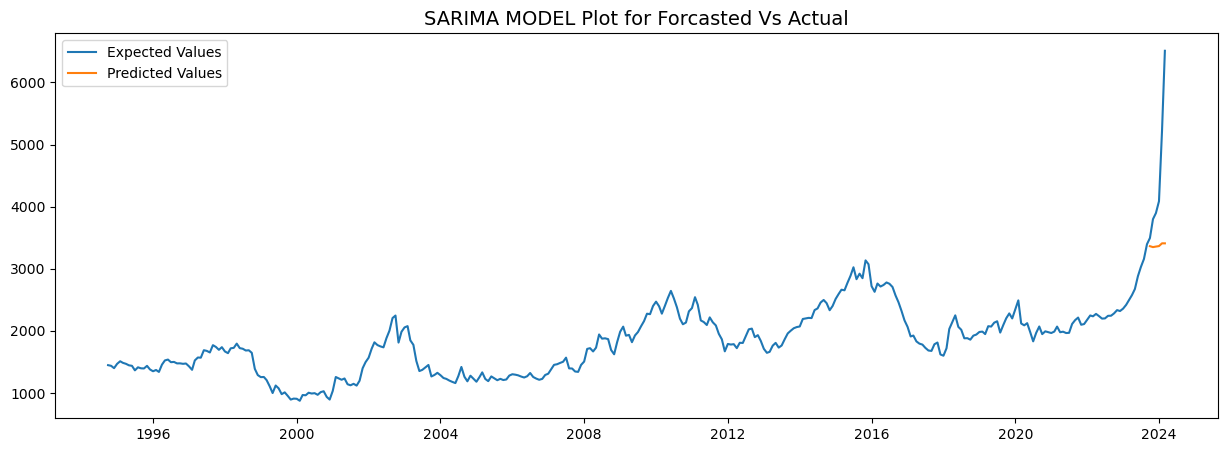

In [208]:
predictions_series = pd.Series(sarimapredictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(mycocoaDF2['Price'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.title('SARIMA MODEL Plot for Forcasted Vs Actual',fontsize="14")
plt.legend(loc="upper left")

plt.show()

In [211]:
RMSESARIMA = np.sqrt(mean_squared_error(test,sarimapredictions))
print('Test RMSE: %.4f' % RMSESARIMA)

Test RMSE: 1524.7230


In [182]:
# The total RMSE value is higher for Sarima Model so We can conclude that Arima is best fitted model for this time series.